In [39]:
# script to read in awas data for flights 5 - 14
# BL TREATMENT - remove samples that are within ~17 km of guam 
# date created: 2/14/2020
# author: sofia chelpon

In [1]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
### ---------------------- READ IN DATA  ---------------------- ###
# path to data
mypath = '/Volumes/scdrive2/contrast_merge_data/contrast_toga_merge/*.nc'
# read in merge all flights 
contrast_init = xr.open_mfdataset(mypath, combine='by_coords')

In [3]:
# change coordinate from "Time" to "Time_UTC"
contrast_init.assign_coords({'Time': contrast_init.Time_UTC.values})
contrast_init.Time.values[640]

numpy.datetime64('2014-01-25T00:14:06.000000000')

In [4]:
### --- desired toga tracers
# empyt dataset to fill with toga data (12 total)
toga_trc_prelim = xr.merge([contrast_init.Acetaldehyde, contrast_init.n_Butane, 
                     contrast_init.i_Butane, contrast_init.Benzene, 
                     contrast_init.C3H8, contrast_init.Methanol,
                     contrast_init.Bromoform, contrast_init.Tetrachloroethylene,  
                     contrast_init.Dibromomethane,  contrast_init.Dichloromethane, 
                     contrast_init.Chloroform, contrast_init.Carbon_Tetrachloride])
print(len(toga_trc_prelim))

### --- aircraft parameters and location 
toga_param_init = xr.merge([contrast_init.GGALT, contrast_init.GGLAT, contrast_init.GGLON, 
                           contrast_init.Time_UTC, contrast_init.WIC])
                      #contrast_init.WIC, contrast_init.PALT, contrast_init.RHUM])

12


In [5]:
studyarea = np.where((toga_param_init.GGLAT.values > 0) & (toga_param_init.GGLAT.values < 25))


/Users/schelpon/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/schelpon/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [8]:
### ---------------------- CONFINE TO NH  ---------------------- ###
# find NH values, what we want 
studyarea = np.where((toga_param_init.GGLAT.values > 0) & (toga_param_init.GGLAT.values < 25))
print(np.size(studyarea))

# keep only NH values, rewrite to toga_param - AIRCRAFT PARAMETERS
toga_param_noblcorr = xr.Dataset()
for ii in toga_param_init.data_vars:
    param = toga_param_init[ii]
    nh_only = param[studyarea].values 
    toga_param_noblcorr[ii] = nh_only
toga_param_noblcorr

# select NH only for all - TRACERS 
toga_trc_twp_noreplace = xr.Dataset()
for ii in toga_trc_prelim.data_vars:
    trc = toga_trc_prelim[ii]
    nh_only = trc[studyarea]
    toga_trc_twp_noreplace[ii] = nh_only


2336


/Users/schelpon/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/schelpon/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
### ---------------------- APPLY DETECTION LIMIT SUBSTITUTION TO TRC ---------------------- ###
# make attribute for detection level 
toga_lods = [5, 0.5, 0.5, 1, 10, 20, 0.1, 0.3, 0.03, 1, 1, 1];

for ii in enumerate(toga_trc_twp_noreplace.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_twp_noreplace[trc].attrs['LOD'] = toga_lods[myind]

### --- replace all LLOD/ULOD (-888, -777) with 1/2 the LOD for each tracer 
toga_trc_pre_blcorr = xr.Dataset()    
for ii in toga_trc_twp_noreplace.data_vars:
    # get this tracer and its LOD 
    trc_vals = toga_trc_twp_noreplace[ii].values
    trc = toga_trc_twp_noreplace[ii]
    
    # -------- locations for fills
    # llod 
    llod = trc.attrs['LLOD']
    where_llod = np.where(trc_vals == llod)
    # ulod 
    ulod = trc.attrs['ULOD']
    where_ulod = np.where(trc_vals == ulod)
    
    # -------- make those locations equal to LOD/2 
    trc_vals[where_llod] = trc.LOD/2
    trc_vals[where_ulod] = trc.LOD/2
    # replace values in Dataarray with that including substituded values, save to var 
    trc.values = trc_vals
    toga_trc_pre_blcorr[ii] = trc
    print(np.nanmax(toga_trc_pre_blcorr[ii]))

4121.9
1899.86
785.37
116.38
513.0
4712.0
2.361
3.01
1.742
96.29
19.21
102.0


In [10]:
### ---------------------- ADD LIFETIMES AS AN ATTRIBUTE ---------------------- ###
# read in from xls file to make dataframe
mypath2 = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_lifetimes_12162019.xlsx'
toga_lifetimes = pd.read_excel(mypath2)

# add attribute to each tracer 
for ii in enumerate(toga_trc_pre_blcorr.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_pre_blcorr[trc].attrs['BL_lifetime'] = toga_lifetimes['BL_tau'][myind]
    toga_trc_pre_blcorr[trc].attrs['UT_lifetime'] = toga_lifetimes['UT_tau'][myind]
    toga_trc_pre_blcorr[trc].attrs['TROPO_lifetime'] = toga_lifetimes['TROPO_tau'][myind]

In [11]:
### ---------------------- REMOVE BL SAMPLES NEAR GUAM ---------------------- ###
# ~111 km/degree lat and ~108 km/degree long
# so this is about 11 km around guam 
# https://www.johndcook.com/how_big_is_a_degree.html
guam_coord = [13.4, 144.8]
cut = 0.16
print((111*0.16), (108*0.16))
guam_lat_cuts = [guam_coord[0]-cut, guam_coord[0]+cut]
guam_lon_cuts = [guam_coord[1]-cut, guam_coord[1]+cut]

# get the regions near guam to mask out and altitudes (not BL)
null_lat = np.where((toga_param_noblcorr.GGLAT > guam_lat_cuts[0]) 
                    & (toga_param_noblcorr.GGLAT < guam_lat_cuts[1]))
null_lon = np.where((toga_param_noblcorr.GGLON > guam_lon_cuts[0]) 
                    & (toga_param_noblcorr.GGLON < guam_lon_cuts[1]))
null_alt = np.where((toga_param_noblcorr.GGALT < 4000))

# get intersection, index list to mask 
near_guam = np.intersect1d(null_lat, null_lon, null_alt)

# get the opposite of that index, NOT near guam 
#not_guam = np.arange(0, len(toga_param.GGALT.values), dtype = float)
#not_guam[near_guam]=np.nan

not_guam = np.arange(0, len(toga_param_noblcorr.GGALT.values))
not_guam = np.delete(not_guam, near_guam)

17.76 17.28


In [12]:
# keep only non-guam values - AIRCRAFT PARAM 
toga_param = xr.Dataset()
for ii in toga_param_noblcorr.coords:
    param = toga_param_noblcorr[ii]
    param_noguam = param[not_guam].values 
    toga_param[ii] = param_noguam

# keep only non-guam values - TRACERS 
toga_trc = xr.Dataset()
for ii in toga_trc_pre_blcorr.data_vars:
    trc = toga_trc_pre_blcorr[ii]
    trc_noguam = trc[not_guam]
    toga_trc[ii] = trc_noguam
    print(np.nanmax(toga_trc[ii]))

537.8
152.01
88.04
92.2
513.0
1233.0
1.638
3.01
1.742
93.0
16.94
102.0


In [13]:
### ---------------------- ADD AC PARAMETERS AS COORDINATES ---------------------- ###
for ii in toga_param.coords:
    my_coord = toga_param[ii]
    toga_trc.coords[ii] = my_coord

/Users/schelpon/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


<xarray.DataArray 'GGALT' (GGALT: 0)>
array([], dtype=float32)
Coordinates:
  * GGALT    (GGALT) float32  <xarray.DataArray 'GGLAT' (GGLAT: 0)>
array([], dtype=float32)
Coordinates:
  * GGLAT    (GGLAT) float32  <xarray.DataArray 'GGLON' (GGLON: 0)>
array([], dtype=float32)
Coordinates:
  * GGLON    (GGLON) float32 


<xarray.Dataset>
Dimensions:               (GGALT: 2277, GGLAT: 2277, GGLON: 2277, Time: 2277, Time_UTC: 2277, WIC: 2277)
Coordinates:
  * Time                  (Time) datetime64[ns] 2014-01-17T00:18:06 ... 2014-02-25T07:18:04
  * GGALT                 (GGALT) float32 3127.166 4212.603 ... 957.75916
  * GGLAT                 (GGLAT) float32 13.379817 13.258845 ... 13.409988
  * GGLON                 (GGLON) float32 144.9935 145.1362 ... 144.63826
  * Time_UTC              (Time_UTC) datetime64[ns] 2014-01-17T00:18:24 ... 2014-02-25T07:18:22
  * WIC                   (WIC) float32 0.15899388 -0.41373205 ... 0.6757683
Data variables:
    Acetaldehyde          (Time) float32 191.2 126.8 nan ... 233.3 323.8 278.9
    n_Butane              (Time) float32 1.51 1.68 1.42 1.14 ... 2.79 3.55 7.69
    i_Butane              (Time) float32 2.49 2.6 2.17 1.09 ... 2.47 3.29 5.17
    Benzene               (Time) float32 nan nan 7.28 8.23 ... 14.91 17.39 19.92
    C3H8                  (Time) float32 41.0 13.0 18.0 5.0 ... 60.0 75.0 69.0
    Methanol              (Time) float32 611.0 378.0 228.0 ... 931.0 905.0 959.0
    Bromoform             (Time) float32 0.689 0.48 0.05 ... 0.644 0.561 0.638
    Tetrachloroethylene   (Time) float32 0.15 0.15 0.15 0.15 ... 1.06 1.28 1.31
    Dibromomethane        (Time) float32 nan nan nan 1.043 ... 0.927 0.89 0.87
    Dichloromethane       (Time) float32 44.49 50.11 42.03 ... 51.22 55.55 59.04
    Chloroform            (Time) float32 9.39 10.29 8.67 ... 10.22 10.87 10.6
    Carbon_Tetrachloride  (Time) float32 97.1 94.3 96.7 94.6 ... 77.1 79.1 81.0

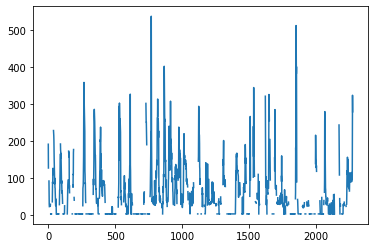

In [14]:
big = np.where(toga_trc.Acetaldehyde.values > 1000)
plt.plot(toga_trc.Acetaldehyde)
print(toga_trc.GGALT[big], toga_trc.GGLAT[big], toga_trc.GGLON[big])

toga_trc

In [15]:
### pickle it! 
toga_trc.to_netcdf(path = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_trace_gases_twp.nc')
print ('finished saving tracers')

finished saving tracers


In [16]:
toga_trc

<xarray.Dataset>
Dimensions:               (GGALT: 2277, GGLAT: 2277, GGLON: 2277, Time: 2277, Time_UTC: 2277, WIC: 2277)
Coordinates:
  * Time                  (Time) datetime64[ns] 2014-01-17T00:18:06 ... 2014-02-25T07:18:04
  * GGALT                 (GGALT) float32 3127.166 4212.603 ... 957.75916
  * GGLAT                 (GGLAT) float32 13.379817 13.258845 ... 13.409988
  * GGLON                 (GGLON) float32 144.9935 145.1362 ... 144.63826
  * Time_UTC              (Time_UTC) datetime64[ns] 2014-01-17T00:18:24 ... 2014-02-25T07:18:22
  * WIC                   (WIC) float32 0.15899388 -0.41373205 ... 0.6757683
Data variables:
    Acetaldehyde          (Time) float32 191.2 126.8 nan ... 233.3 323.8 278.9
    n_Butane              (Time) float32 1.51 1.68 1.42 1.14 ... 2.79 3.55 7.69
    i_Butane              (Time) float32 2.49 2.6 2.17 1.09 ... 2.47 3.29 5.17
    Benzene               (Time) float32 nan nan 7.28 8.23 ... 14.91 17.39 19.92
    C3H8                  (Time) float32 41.0 13.0 18.0 5.0 ... 60.0 75.0 69.0
    Methanol              (Time) float32 611.0 378.0 228.0 ... 931.0 905.0 959.0
    Bromoform             (Time) float32 0.689 0.48 0.05 ... 0.644 0.561 0.638
    Tetrachloroethylene   (Time) float32 0.15 0.15 0.15 0.15 ... 1.06 1.28 1.31
    Dibromomethane        (Time) float32 nan nan nan 1.043 ... 0.927 0.89 0.87
    Dichloromethane       (Time) float32 44.49 50.11 42.03 ... 51.22 55.55 59.04
    Chloroform            (Time) float32 9.39 10.29 8.67 ... 10.22 10.87 10.6
    Carbon_Tetrachloride  (Time) float32 97.1 94.3 96.7 94.6 ... 77.1 79.1 81.0